# Solving CIFAR 10 using Keras (Work in progress)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

This notebook attempts to classify those images.

In [2]:
# Import all modules
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
#from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

In [3]:
#Declaring Variables
batch_size = 32 #Smaller Batch size means more updates in one epoch

num_classes = 10 
epochs = 100 #Repeat 100 times

In [4]:
#Load the Dataset 
(x_train, y_train), (x_test,y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 14s 0us/step


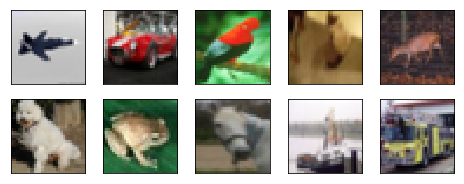

In [5]:
# Print 10 random images 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1 + i, xticks=[],yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    #ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

We now need to normalize the pixel values. This means to turn them from in the range of 0-255 to be between 0 and 1. 

In [6]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [ ]:
#Defining our model 
def base_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(521))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    #Train model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

cnn_n = base_model()
cnn_n.summary()
 
#Fit model
 
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)     
    

# 6 Layer Model
We will now create a 6 layer model to compare with the 4 layer model created above. 

In [ ]:
def six_layer():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Train model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
cnn_n6 = six_layer()
cnn_n6.summary()
 
# Fit model
 
cnn6 = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

# Plotting our accuracy and loss

# 4 Layer CNN

In [ ]:
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.plot()

In [ ]:
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# 6 Layer CNN

In [ ]:
plt.figure(1)
plt.plot(cnn6.history['acc'],'r')
plt.plot(cnn6.history['val_acc'],'g')
plt.plot()

In [ ]:
scores = cnn_n6.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Confusion Matrix for 4 layer

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

# Confustion Matrix for 6 layer 

In [ ]:
Y_pred = cnn_n6.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()